In [1]:
from random import randint
import pathlib
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import pickle

In [2]:
folder_name = 'fakeRandom'
output_folder = pathlib.Path('.').joinpath(folder_name).absolute()
output_folder

PosixPath('/home/loot/Desktop/concurrency_theory/resources/fakeRandom')

In [3]:
def make_file(path: pathlib.Path, total, limit):
    numbers = []
    
    while total > 0:
        numbers.append(randint(1, limit))
        total -= numbers[-1]
        
    numbers[-1] += total
    
    path.touch()
    path.write_text("\n".join(map(str, numbers)))
    

def generate_fake_random_imputs(where : pathlib.Path, producers, consumers, total, limit):
    if where.exists():
        for file in where.iterdir():
            file.unlink()
    else:
        where.mkdir()
    
    p_portion = total // producers
    for i in range(producers - 1):
        make_file(where.joinpath(f"prod{i}"), p_portion, limit)
    left = total - p_portion * (producers - 1)
    make_file(where.joinpath(f"prod{producers-1}"), left, limit)
    
    c_portion = total // consumers
    for i in range(consumers - 1):
        make_file(where.joinpath(f"cons{i}"), c_portion, limit)
    left = total - c_portion * (consumers - 1)
    make_file(where.joinpath(f"cons{consumers-1}"), left, limit)
    

In [4]:
producers = 2
consumers = 3
total = 20
limit = 3

#ao = "true"
ao = "false"
buffer_time = 20
task_time = 20
task_count = 40
capacity = 100

generate_fake_random_imputs(output_folder, producers, consumers, total, limit)

In [5]:
args_base = list("/home/loot/.jdks/openjdk-15/bin/java -javaagent:/home/loot/.local/share/JetBrains/Toolbox/apps/IDEA-C/ch-0/202.7660.26/lib/idea_rt.jar=46285:/home/loot/.local/share/JetBrains/Toolbox/apps/IDEA-C/ch-0/202.7660.26/bin -Dfile.encoding=UTF-8 -classpath /home/loot/Desktop/concurrency_theory/out/production/concurrency_theory comparison.Main".split())

In [6]:
args = ["time", "-f", "%U,%S,%e,%P"] + args_base
args.append(ao)
args += list(map(str, [buffer_time, task_time, task_count, capacity, producers, consumers]))
args.append(str(output_folder))

res = subprocess.run(args, capture_output=True)

In [7]:
def process_result(res : subprocess.CompletedProcess):
    data = {k: v.strip() for k, v in zip(["user", "sys", "elapsed", "cpu"], list(res.stderr.decode().split(",")))}
    for k in ["user", "sys", "elapsed"]:
        data[k] = float(data[k])
        
    data['cpu'] = int(data['cpu'][:-1])
    return data

process_result(res)

{'user': 0.27, 'sys': 0.05, 'elapsed': 0.39, 'cpu': 82}

In [8]:
def make_command(ao, buffer_time, task_time, task_count, capacity, producers, consumers):
    args = ["time", "-f", "%U,%S,%e,%P"] + args_base
    args.append(ao)
    args += list(map(str, [buffer_time, task_time, task_count, capacity, producers, consumers]))
    args.append(str(output_folder))
    return args

In [124]:
def summarize_results(results : list):
    summary = {}
    for key in results[0].keys():
        l = list(map(lambda x: x[key], results))
        summary[key] = np.mean(l)
        summary[key + '_std'] = np.std(l)
    return summary

buffer: 1000
total:  10000

producers/consumers: 1, 8, 128
limit: 10, 100, 500

buffer_time: 100
task_time: 10, 100, 1000
task_count: 0, 1000, 1000, 10000

In [225]:
PRODUCERS = 3
CONSUMERS = 3
BUFFER_TIME = 15000 # 150000
TASK_TIME = 10000
TASK_COUNT = 3000

CAPACITY = 10
LIMIT = CAPACITY // 2
TOTAL = 100 * CAPACITY

BUFFER_TIME / TASK_TIME, TASK_TIME * TASK_COUNT / (BUFFER_TIME * TOTAL)

(1.5, 2.0)

In [29]:
# with open("all_results.pkl", 'wb') as f:
#     pickle.dump(all_results, f)
# all_results = {}
# with open("all_results.pkl", 'rb') as f:
#     all_results = pickle.load(f)
# all_results

In [141]:
REPETITIONS = 100

In [278]:
[(i+1)*5000 for i in range(5)], [1000*i for i in range(6)]

([5000, 10000, 15000, 20000, 25000], [0, 1000, 2000, 3000, 4000, 5000])

In [142]:
x = [(i+1)*5000 for i in range(5)]
x_name = 'sinus repetitions'
y = [1000*i for i in range(6)]
y_name = 'task_count'
result_name = 'Extra Task'

producers = PRODUCERS
consumers = CONSUMERS
total = TOTAL
limit = LIMIT
buffer_time = BUFFER_TIME
task_time = TASK_TIME
task_count = TASK_COUNT
capacity = CAPACITY

generate_fake_random_imputs(output_folder, producers, consumers, total, limit)

plot_data = {'x': x, 'y': y, 'data': defaultdict(list), 'x_name': x_name, 'y_name': y_name}

for task_time in tqdm(x):
    plot_data['data']["AO"].append([])
    plot_data['data']["Monitor"].append([])
    for task_count in y:
        for ao in ["true", "false"]:
            args = make_command(ao, buffer_time, task_time, task_count, capacity, producers, consumers)
            
            results = []
            for i in range(REPETITIONS):
                r = subprocess.run(args, capture_output=True)
                results.append(process_result(r))
                
            result = summarize_results(results)
            solution_name = "AO" if ao == "true" else "Monitor"
            plot_data['data'][solution_name][-1].append(result)
            
all_results[result_name] = plot_data

100%|██████████| 5/5 [1:39:44<00:00, 1196.86s/it]


In [214]:
x = [(i+1)*5000 for i in range(5)]
x_name = 'sinus repetitions'
y = [1000*i for i in range(6)]
y_name = 'task_count'
result_name = 'Extra Task 2'

producers = 8
consumers = 8
total = TOTAL
limit = LIMIT
buffer_time = BUFFER_TIME
task_time = TASK_TIME
task_count = TASK_COUNT
capacity = CAPACITY
repetitions = REPETITIONS
generate_fake_random_imputs(output_folder, producers, consumers, total, limit)

plot_data = {'x': x, 'y': y, 'data': defaultdict(list), 'x_name': x_name, 'y_name': y_name}

for task_time in tqdm(x):
    plot_data['data']["AO"].append([])
    plot_data['data']["Monitor"].append([])
    for task_count in y:
        for ao in ["true", "false"]:
            args = make_command(ao, buffer_time, task_time, task_count, capacity, producers, consumers)
            
            results = []
            for i in range(repetitions):
                r = subprocess.run(args, capture_output=True)
                results.append(process_result(r))
                
            result = summarize_results(results)
            solution_name = "AO" if ao == "true" else "Monitor"
            plot_data['data'][solution_name][-1].append(result)
            
all_results[result_name] = plot_data

100%|██████████| 5/5 [2:14:13<00:00, 1610.63s/it]


In [218]:
x = [(i+1)*5000 for i in range(5)]
x_name = 'sinus repetitions'
y = [1000*i for i in range(6)]
y_name = 'task_count'
result_name = 'Extra Task 3'

producers = 3
consumers = 3
total = TOTAL
limit = LIMIT
buffer_time = BUFFER_TIME
task_time = TASK_TIME
task_count = TASK_COUNT
capacity = CAPACITY
repetitions = REPETITIONS
generate_fake_random_imputs(output_folder, producers, consumers, total, limit)

plot_data = {'x': x, 'y': y, 'data': defaultdict(list), 'x_name': x_name, 'y_name': y_name}

for task_time in tqdm(x):
    plot_data['data']["AO"].append([])
    plot_data['data']["Monitor"].append([])
    for task_count in y:
        for ao in ["true", "false"]:
            args = make_command(ao, buffer_time, task_time, task_count, capacity, producers, consumers)
            
            results = []
            for i in range(repetitions):
                r = subprocess.run(args, capture_output=True)
                results.append(process_result(r))
                
            result = summarize_results(results)
            solution_name = "AO" if ao == "true" else "Monitor"
            plot_data['data'][solution_name][-1].append(result)
            
all_results[result_name] = plot_data

100%|██████████| 5/5 [2:05:39<00:00, 1507.96s/it]


In [317]:
[5000*(i+1) for i in range(5)]

[5000, 10000, 15000, 20000, 25000]

In [260]:
x = [2*i for i in [1, 2, 3, 5, 10, 20, 30]]
x_name = 'threads'
y = [5000*(i+1) for i in range(5)]
y_name = 'task count'
result_name = 'Threads & Task count'

total = TOTAL
limit = LIMIT
buffer_time = BUFFER_TIME
task_time = TASK_TIME
task_count = TASK_COUNT
capacity = CAPACITY
repetitions = REPETITIONS // 2

plot_data = {'y': x, 'x': y, 'data': defaultdict(list), 'y_name': x_name, 'x_name': y_name}

for threads in tqdm(x):
    producers = threads // 2
    consumers = producers

    generate_fake_random_imputs(output_folder, producers, consumers, total, limit)

    plot_data['data']["AO"].append([])
    plot_data['data']["Monitor"].append([])
    for task_count in y:
        
        for ao in ["true", "false"]:
            
            args = make_command(ao, buffer_time, task_time, task_count, capacity, producers, consumers)

            results = []
            for i in range(repetitions):
                r = subprocess.run(args, capture_output=True)
                results.append(process_result(r))
                
            res = summarize_results(results)
            solution_name = "AO" if ao == "true" else "Monitor"
            plot_data['data'][solution_name][-1].append(res)
            
            
all_results[result_name] = plot_data

100%|██████████| 7/7 [2:12:04<00:00, 1132.04s/it]


In [261]:
x = [1, 10, 100]
x_name = 'limit'
y = [2, 10, 100, 1000]
y_name = 'capacity multiplier'
result_name = 'Limit & Capacity'

producers = 3
consumers = 3
total = TOTAL
limit = LIMIT
buffer_time = BUFFER_TIME
task_time = TASK_TIME
task_count = TASK_COUNT
capacity = CAPACITY


plot_data = {'x': x, 'y': y, 'data': defaultdict(list), 'x_name': x_name, 'y_name': y_name}

for limit in tqdm(x):
    generate_fake_random_imputs(output_folder, producers, consumers, total, limit)
    
    plot_data['data']["AO"].append([])
    plot_data['data']["Monitor"].append([])
    for mul in tqdm(y):
        capacity = limit * mul    
        
        for ao in ["true", "false"]:
            
            args = make_command(ao, buffer_time, task_time, task_count, capacity, producers, consumers)

            results = []
            for i in range(REPETITIONS):
                r = subprocess.run(args, capture_output=True)
                results.append(process_result(r))
                
            res = summarize_results(results)
            solution_name = "AO" if ao == "true" else "Monitor"
            plot_data['data'][solution_name][-1].append( res)
            
all_results[result_name] = plot_data

100%|██████████| 3/3 [30:05<00:00, 601.83s/it]


In [222]:
def plot_3d(data, which_z, x_name="", y_name="", z_name="", title="", rotate=False, elev=None, azim=None):
    x_list = data['x']
    y_list = data['y']
    if rotate:
        x_list = x_list[::-1]
    
    x = np.array([[x_val]*len(y_list) for x_val in x_list])
    y = np.array([y_list for i in range(len(x_list))])
    
    fig = plt.figure(figsize=(8, 16))
    ax = fig.add_subplot(211, projection='3d')
    
    colors = {"AO": 'green', "Monitor": "blue"}
    
    ao = None
    mon = None
    for solution, all_results in data['data'].items():
        z = []
        for results_x in all_results:
            z.append([run_result[which_z] for run_result in results_x])
       # print(z)
        z = np.array(z)
        if rotate:
            z = np.rot90(z)
    #    z = np.log(z)
        if solution == "AO":
            ao = z
        else:
            mon = z
        ax.plot_surface(x, y, z, label=solution, color=colors[solution], edgecolor=colors[solution], alpha=0.3)
        
    ax.set_title(title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)  
    if elev and azim:
        ax.view_init(elev=elev, azim=azim)
    for tick in ax.get_xticklabels():
        tick.set_rotation(5)
    
    col1_patch = mpatches.Patch(color="green", label="AO")
    col2_patch = mpatches.Patch(color="blue", label="Monitor")
    ax.legend(handles=[col1_patch, col2_patch])

#     ax.legend()
    # plt.show()
    ax = fig.add_subplot(212, projection='3d')
    if elev and azim:
        ax.view_init(elev=elev, azim=azim)
    mpatches.Patch(color="green", label="AO")
#     col2_patch = mpatches.Patch(color="blue", label="Monitor")
    ax.legend(handles=[col1_patch, col2_patch])
#     fig = plt.figure(figsize=(8, 8))
#     ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, 100 * (mon / ao), label="Monitor", color='blue', edgecolor='blue', alpha=0.3)
    ax.plot_surface(x, y, 100 + np.zeros(ao.shape), label="AO", color='green', edgecolor='green', alpha=0.3)
    
    ax.set_title(title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel("Resources used [% AO]")
    for tick in ax.get_xticklabels():
        tick.set_rotation(5)

  #  ax.set_zscale('log')
   # ax.set_zlim(0)
#     ax.legend()
    plt.show()
        
        
#plot_3d(plot_data, 'user', 'task time [ms]', 'task count [ms]', 'User time depending on task')

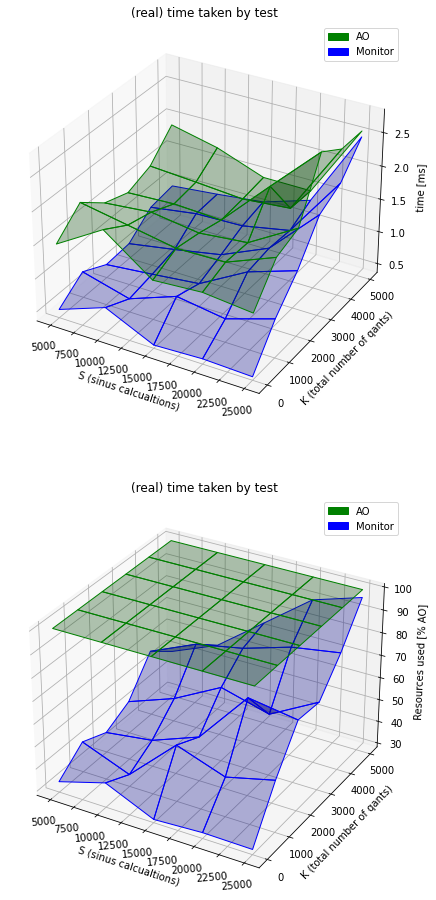

In [293]:
plot_data = all_results['Extra Task 2']
plot_3d(plot_data, 'elapsed', f"S (sinus calcualtions)", f"K (total number of qants)", "time [ms]", '(real) time taken by test')

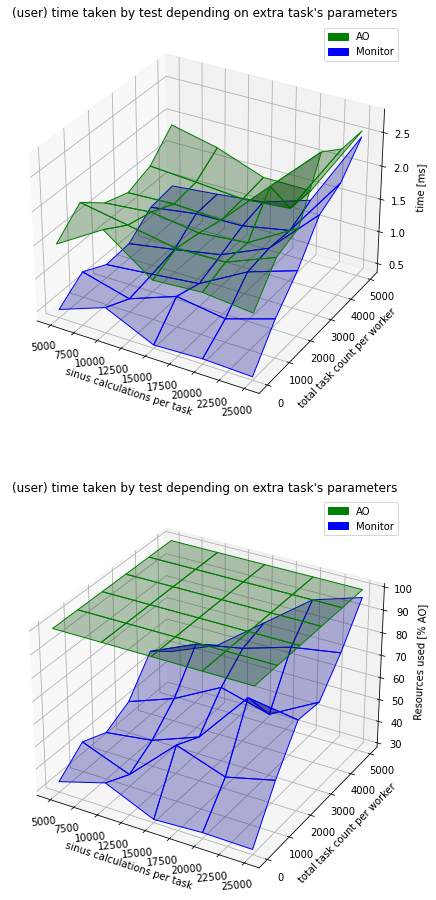

In [216]:
plot_data = all_results['Extra Task 2']
plot_3d(plot_data, 'elapsed', f"sinus calculations per task", f"total task count per worker", "time [ms]", '(user) time taken by test depending on extra task\'s parameters', 
        elev=0, azim=280)

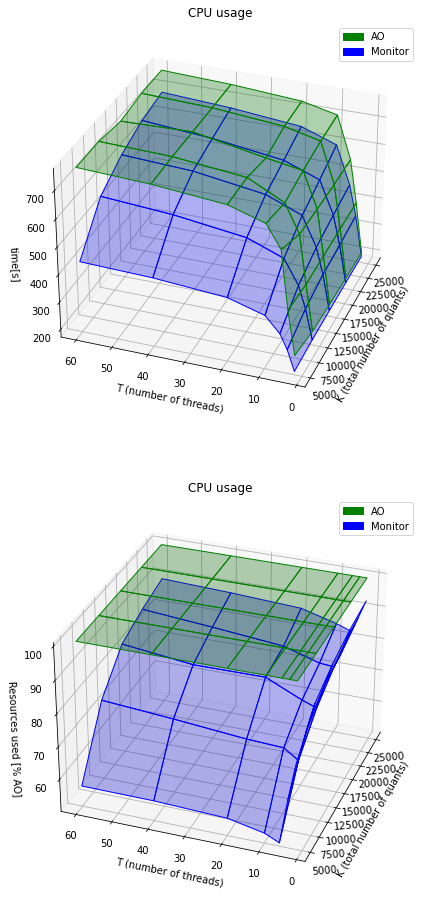

In [313]:
plot_data = all_results['Threads & Task count']
plot_3d(plot_data, 'cpu', f"K (total number of quants)", f"T (number of threads)", "time[s]", 'CPU usage', rotate=True, elev=30, azim=200)

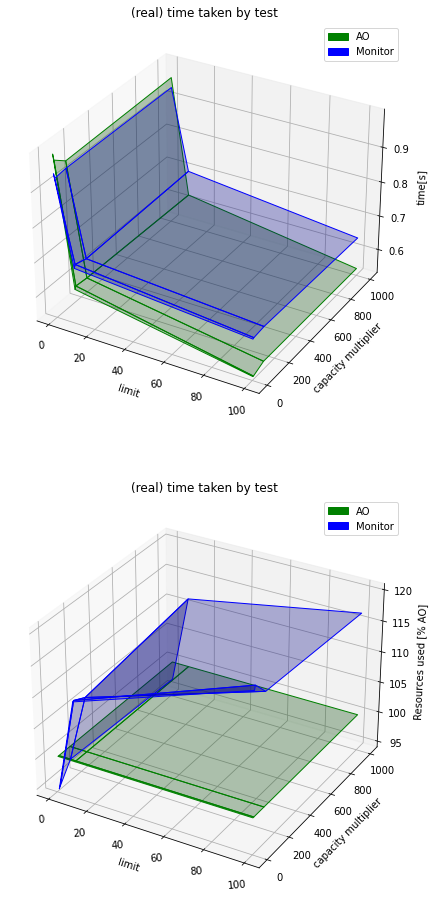

In [318]:
plot_data = all_results['Limit & Capacity']
plot_3d(plot_data, 'elapsed', f"{plot_data['x_name']}", f"{plot_data['y_name']}", "time[s]", '(real) time taken by test', elev=0, azim=1)

In [271]:
with open("results_100_rep.pkl", 'wb') as f:
    pickle.dump(all_results, f)